In [67]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from scipy.interpolate import make_interp_spline

from scipy.spatial import ConvexHull

In [68]:
import sys
sys.path.append(r'../')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [69]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/repartrition_01-03/'               # Harmon server
name_project

'project_repartrition/output_repar_06-01/'

In [70]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartrition/output_repar_06-01/


In [71]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [72]:
name_project_based = info_basic['name_project_based']
dir_project_based = os.path.join(dir_project_workspace, name_project_based)
print('dir_project_based: ', dir_project_based)

dir_project_based:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/


In [73]:
filename = dir_project_based+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_based = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi_based = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [74]:
key_subworks_based = info_basic_based['key_subworks']
key_subworks_based

['04-02',
 '05-02',
 '06-02',
 '07-02',
 '08-02',
 '09-02',
 '10-02',
 '11-02',
 '12-02',
 '13-02',
 '14-02',
 '15-02',
 '16-02',
 '17-02',
 '18-02',
 '19-02',
 '20-02',
 '21-02',
 '22-02',
 '23-02',
 '24-02',
 '25-02',
 '26-02',
 '27-02',
 '28-02',
 '29-02',
 '30-02',
 '31-02',
 '32-02',
 '33-02',
 '34-02',
 '35-02',
 '36-02',
 '37-02',
 '38-02',
 '39-02',
 '40-02',
 '41-02',
 '42-02',
 '43-02',
 '44-02',
 '45-02',
 '46-02',
 '47-02',
 '48-02',
 '49-02',
 '50-02',
 '51-02',
 '52-02',
 '53-02',
 '54-02',
 '55-02',
 '56-02',
 '57-02',
 '04-03',
 '05-03',
 '06-03',
 '07-03',
 '08-03',
 '09-03',
 '10-03',
 '11-03',
 '12-03',
 '13-03',
 '14-03',
 '15-03',
 '16-03',
 '17-03',
 '18-03',
 '19-03',
 '20-03',
 '21-03',
 '22-03',
 '23-03',
 '24-03',
 '25-03',
 '26-03',
 '27-03',
 '28-03',
 '29-03',
 '30-03',
 '31-03',
 '32-03',
 '33-03',
 '34-03',
 '35-03',
 '36-03',
 '37-03',
 '38-03',
 '39-03',
 '40-03',
 '41-03',
 '42-03',
 '43-03',
 '44-03',
 '45-03',
 '46-03',
 '47-03',
 '48-03',
 '49-03',


In [75]:
dir_image = dir_project+info_basic['dir_image']

### Calculate each F-J spectrograms' average Velocity

In [76]:
def calculate_velocity(key_subwork):
    global f
    global c
    global info_basic
    global info_basic_based
    global info_basic_bi_based  
    global f_sample
    global flag_1
    global flag_2
    global c_mean
    global c_mean_data
    global flag_plot
    global dir_project_based
    global dir_image

    dir_ds_based = dir_project_based + info_basic_based['dir_ds']
    ds = h5py.File(dir_ds_based+'ds_'+key_subwork+'.h5', 'r')

    ds_remove = ds['ds_remove'][0]
    #ds_new_1 = ds_remove[c < flag_1[0],:]
    #ds_new_2 = ds_remove[c < flag_2[0],:]
    f_sample = []
    c_sample = []
    c_new = c[np.logical_and(c>flag_1[0],c < flag_1[1])]
    for index_f in range(len(f)):
        if f[index_f] < flag_1[2] or f[index_f] > flag_2[3]:
            continue
        if f[index_f] >= flag_1[2] and f[index_f] < flag_1[3]:
            index_c = np.where(ds_remove[np.logical_and(c>flag_1[0],c < flag_1[1]),index_f] == np.max(ds_remove[np.logical_and(c>flag_1[0],c < flag_1[1]),index_f] ))[0][0]
        else:
            index_c = np.where(ds_remove[np.logical_and(c>flag_2[0],c < flag_2[1]),index_f]  == np.max(ds_remove[np.logical_and(c>flag_2[0],c < flag_2[1]),index_f] ))[0][0]
        f_sample.append(f[index_f])
        c_sample.append(c_new[index_c])
    c_mean[key_subwork] = np.mean(c_sample)
    f_smooth = np.linspace(min(f_sample), max(f_sample), 100)  # np.linspace 等差数列,从x.min()到x.max()生成300个数，便于后续插值
    c_smooth = make_interp_spline(f_sample, c_sample)(f_smooth)
    print('finish '+key_subwork)
    if flag_plot == 1:
        fig,ax = plt.subplots(1,1,figsize=(8,6))
        title0 = "Linear stack dispersion curve "
        ax = plotlib.plot_fj(ax,ds_remove,title0,f,c,0,c_map='jet')
        index_f = 400
        f_p = f[index_f]
        #index_c = np.where(np.abs(ds_remove[:,f==f_p]) == np.max(np.abs(ds_remove[:,f==f_p])))[0][0]
        #ax.scatter(f_sample,c_sample,c='g',s=20)
        ax.scatter(f_smooth,c_smooth,c='g',s=20)
        #plt.savefig(dir_image + 'Autopick_'+key_subwork+'.png')
        plt.close()

In [77]:
f = info_basic_bi_based['f']
c = np.linspace(info_basic_based['c_min'],info_basic_based['c_max'],info_basic_based['c_num'])

In [78]:
"""
flag_1 = [1.2,2,4]
flag_2 = [1.1,4,5]
flag_plot = 1
flag_multiple = 1
key_subwork_sample = key_subworks_based[0:100:10]
c_mean = {}
c_mean_data = np.zeros(len(f))
for key_subwork in key_subwork_sample:
    calculate_velocity(key_subwork)
"""

'\nflag_1 = [1.2,2,4]\nflag_2 = [1.1,4,5]\nflag_plot = 1\nflag_multiple = 1\nkey_subwork_sample = key_subworks_based[0:100:10]\nc_mean = {}\nc_mean_data = np.zeros(len(f))\nfor key_subwork in key_subwork_sample:\n    calculate_velocity(key_subwork)\n'

In [79]:
flag_1 = [0.3,0.9,8,10]
flag_2 = [0.3,0.72,10,16]
nThreads = 5
c_mean = {}
c_mean_data = np.zeros(len(f))
flag_plot = 0
flag_multiple = 1

In [80]:
if flag_multiple ==1:
    pool = ThreadPoolExecutor(max_workers = nThreads)
    for key_subwork in key_subworks_based:
        pool.submit(calculate_velocity,key_subwork)
    pool.shutdown()
else:
    for key_subwork in key_subworks_based:
        calculate_velocity(key_subwork)

### Plot

In [81]:
stalistname_all = info_basic_based['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_all =  stainfo['latitude'].tolist() 
lon_all =  stainfo['longitude'].tolist() 

In [82]:
#key_subworks_based = info_basic['key_subworks_based']
c_mean_data = []
lat_this = []
lon_this = []
for key_subwork in key_subworks_based:
    key = 'R'+key_subwork[0:2]+key_subwork[3:]
    if key in stalist_all:
        lat_this.append(lat_all[stalist_all.index(key)])
        lon_this.append(lon_all[stalist_all.index(key)])
    else:
        key1 = 'R' + str(int(key_subwork[0:2])-1).zfill(2)+key_subwork[3:5]
        key2 = 'R' + str(int(key_subwork[0:2])+1).zfill(2)+key_subwork[3:5]
        indx1 = stalist_all.index(key1)
        indx2 = stalist_all.index(key2)
        lat_this.append((lat_all[indx1]+lat_all[indx2])/2)
        lon_this.append((lon_all[indx1]+lon_all[indx2])/2)
    c_mean_data.append(c_mean[key_subwork])

In [83]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

(-116.59694834999999,
 -116.58567665000001,
 33.534672199722195,
 33.542851800013224)

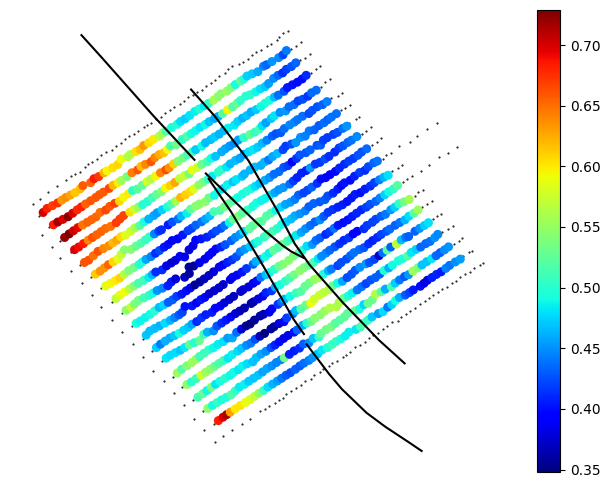

In [84]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
c_min = 0.4
c_max = 0.5
ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
im = ax.scatter(lon_this, lat_this,c=c_mean_data,cmap='jet',s=30)
#im = ax.scatter(lon_this, lat_this,c=c_mean_data,cmap='jet',s=30,vmin = c_min,vmax = c_max)
plt.colorbar(im)
    
ax.axis('off')

### Cluster

In [ ]:
def hierarchical_clustering(lons, lats, values, n_clusters):
    coordinates_and_values = np.column_stack((lons, lats, values))
    scaler = StandardScaler()
    coordinates_and_values_scaled = scaler.fit_transform(coordinates_and_values)
    
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = hierarchical.fit_predict(coordinates_and_values_scaled)
    
    return clusters

In [ ]:
n_clusters = 3
clusters = hierarchical_clustering(lon_this, lat_this, c_mean_data, n_clusters)

In [ ]:
c_min = 0.6
c_max = 1.
# ax00
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax[0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k',lw = 1)
#im = ax[0].scatter(lon_this, lat_this,c=c_mean_data,cmap='jet',s=30)
im = ax[0].scatter(lon_this, lat_this,c=c_mean_data,cmap='jet',s=50,vmin = c_min,vmax = c_max)
plt.colorbar(im,ax = ax[0],shrink=0.5)
ax[0].axis('off')

# ax01
for cluster in range(n_clusters):
    cluster_points = np.column_stack((np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster]))
    ax[1].scatter(cluster_points[:, 0], cluster_points[:, 1], s=40, marker='o' if cluster == 0 else 's' if cluster == 1 else '^' if cluster == 2 else 'D', label=f'Cluster {cluster + 1}')
#plt.legend()
ax[1].axis('off')
# 给第二个子图添加colorbar
plt.colorbar(im, ax=ax[1], shrink=0.5)
for i in range(len(faults)):
    ax[1].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k',lw = 1)
plt.savefig(dir_image + 'Autopick_Cluster.png')

In [ ]:

n_cols = int(np.ceil(np.sqrt(n_clusters)))
n_rows = int(np.ceil(n_clusters / n_cols))
fig = plt.figure(figsize=(8*(n_rows+1), 8*n_cols))


for cluster in range(n_clusters):
    col_num = cluster % n_cols
    row_num = int(cluster / n_cols)
    ax = plt.subplot(n_rows+1, n_cols, n_cols+cluster + 1)
    ax.scatter(lon_all, lat_all,marker='.',color='k',s=10)
    for i in range(len(faults)):
        plt.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'r',lw = 1)
    im = ax.scatter(np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster],c=np.array(c_mean_data)[clusters == cluster],cmap='jet',s=100,vmin = c_min,vmax = c_max)
    ax.axis('off')
    #plt.colorbar(im,ax=ax[cluster])
plt.tight_layout()
plt.savefig(dir_image + 'Autopick_Cluster_all.png')

In [ ]:
# 每个cluster写入Zone分区
Zones = {}
for cluster in range(n_clusters):
    Zones[cluster] = []
    for i in range(len(lon_this)):
        if clusters[i] == cluster:
            Zones[cluster].append(key_subworks_based[i])

### Storage for different partrition

In [ ]:
stalistname_based = info_basic_based['stalistname']
sta_all = pd.read_excel(dir_project_based + stalistname_based,sheet_name = None,engine='openpyxl') 

In [ ]:
sta_all.keys()

In [ ]:
Zones.keys()

In [ ]:
filename = 'stations_info.xlsx'
if os.path.exists(dir_project+filename):
    os.remove(dir_project+filename)

In [ ]:
for key in Zones.keys():
    zone = Zones[key]
    stalist_zone = set()
    for key_subwork in zone:
        stainfo = sta_all[key_subwork]
        stalist = set(stainfo['Station'].tolist())
        stalist_zone = stalist_zone.union(stalist)
    stalist_zone = list(stalist_zone)
    df = pd.DataFrame()
    df['Station'] = stalist_zone
    df['latitude'] = [lat_all[stalist_all.index(key_this)] for key_this in stalist_zone]
    df['longitude'] = [lon_all[stalist_all.index(key_this)] for key_this in stalist_zone]
    #df['c_mean'] = [c_mean[key_this[1:3]+'-'+key_this[3:]] for key_this in stalist_zone]
    #df.to_excel(dir_project+filename,sheet_name=str(key),index=False)
    # 将df写入到filename的excel文件中
    if not os.path.exists(dir_project+filename):
        df.to_excel(dir_project+filename, sheet_name=str(key),index=False)
        books = load_workbook(dir_project+filename)
        writers = pd.ExcelWriter(dir_project+filename, engine='openpyxl')
        writers.book = books
    else:
        df.to_excel(writers,str(key),index=False)
    print('finish '+str(key)+'\n')
info_basic['stalistname'] = filename
info_basic['stalistname_all'] = info_basic_based['stalistname_all']
writers.save()

In [ ]:
info_basic_bi['c_mean'] = c_mean
info_basic['key_subworks'] = [str(key) for key in Zones.keys()]
for key in Zones.keys():
    info_basic['key_this_'+str(key)] = Zones[key]

In [ ]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)
np.save(dir_project + '/Basic_info.npy', info_basic_bi)